[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbamman/anlp25/blob/main/10.llms/Shot%20Selection.ipynb)

Given a dataset of labeled (x,y) examples, how do you select the examples used as shots in few-shot learning?  [Albalak et al. 2024](https://arxiv.org/pdf/2402.16827) provides a great overview of such data selection strategies for large language models, but in this homework we'll focus on a simple one from [Liu et al. 2021](https://arxiv.org/pdf/2101.06804): given a test data point $x_{test}$, find the $n$ closest points in the training data (by cosine similarity to sentence embeddings of those points).  In this framework, each data point that you want to predict will have a different set of shots selected for it.

This is the algorithm we will be implementing:

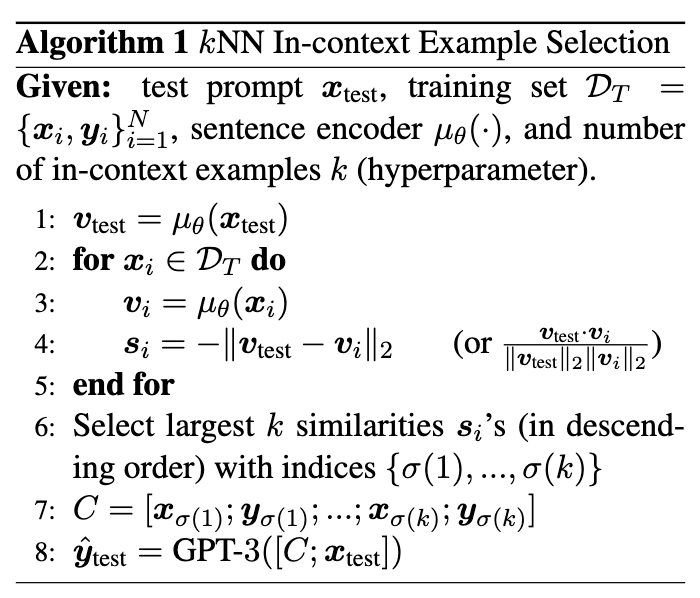

## Dataset

Here's the data we'll use.  This is the subject classification task from the Library of Congress ($x$ = the title of a book and $y$ = a choice of a single subject classification). Be sure to adjust the prompt categories in the example below to reflect the classes you're trying to predict.

In [ ]:
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/train.200.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/dev.100.tsv

In [ ]:
lc_classification = {
    "A": "GENERAL WORKS",
    "B": "PHILOSOPHY. PSYCHOLOGY. RELIGION",
    "C": "AUXILIARY SCIENCES OF HISTORY",
    "D": "WORLD HISTORY AND HISTORY OF EUROPE, ASIA, AFRICA, AUSTRALIA, NEW ZEALAND, ETC.",
    "E": "HISTORY OF THE AMERICAS",
    "F": "HISTORY OF THE AMERICAS",
    "G": "GEOGRAPHY. ANTHROPOLOGY. RECREATION",
    "H": "SOCIAL SCIENCES",
    "J": "POLITICAL SCIENCE",
    "K": "LAW",
    "L": "EDUCATION",
    "M": "MUSIC AND BOOKS ON MUSIC",
    "N": "FINE ARTS",
    "P": "LANGUAGE AND LITERATURE",
    "Q": "SCIENCE",
    "R": "MEDICINE",
    "S": "AGRICULTURE",
    "T": "TECHNOLOGY",
    "U": "MILITARY SCIENCE",
    "V": "NAVAL SCIENCE",
    "Z": "BIBLIOGRAPHY. LIBRARY SCIENCE. INFORMATION RESOURCES (GENERAL)"
}

def read_data(filepath):
    labels = []
    texts = []
    with open(filepath, "r") as f:
        for line in f:
            label, text, _ = line.strip().split("\t")
            labels.append(lc_classification[label])
            texts.append(text)
    return texts, labels

In [ ]:
trainX, trainY = read_data("./train.200.tsv")

In [ ]:
devX, devY = read_data("./dev.100.tsv")

## Nearest neighbors

We will first embed all of the training examples, then define a nearest neighbors function.

In [ ]:
import torch

In [ ]:
from sentence_transformers import SentenceTransformer

def create_nn_search(sentences):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(sentences)

    def search(query, k=5):
        # return the top k nearest indices
        query_vec = model.encode(query)
        similarities = model.similarity(query_vec, embeddings)
        topk = torch.argsort(similarities.squeeze())[-k:]
        return list(topk)[::-1]
    return search
        
        

In [ ]:
nn_search = create_nn_search(trainX)

What are the three nearest neighbors in the training set for the title "Flemish paintings in the Metropolitan Museum of Art "?

## LLM Prompting

We will evaluate 3-shot prompting with a random sample as well as with the 3 nearest neighbors to the target.

In [ ]:
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-4B", device_map="cuda", dtype="auto")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B")

In [ ]:
from textwrap import dedent
import itertools

def classify_with_prompt(labels, shots, target_x, thinking=False):
    newline = "\n"
    system_prompt = dedent(f"""
        You're a helpful assistant for text classification. You'll be given an input text and need to output a single choice from the following set of categories:
        {newline.join(labels)}
        Pick one of those labels and do not generate any other text.
    """).strip()
    
    messages = [
        {"role": "system", "content": system_prompt},
    ]
    messages += itertools.chain(*[
        ({"role": "user", "content": shot["X"]}, {"role": "assistant", "content": shot["y"]})
        for shot in shots
    ])
    messages += [
        {"role": "user", "content": target_x}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=thinking # Switches between thinking and non-thinking modes. Default is True.
    )
    
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    
    # conduct text completion
    generated = model.generate(
        **model_inputs,
        max_new_tokens=100
    )

    # let's break this down:
    #                      | we take the element of the batch (our batch size is 1)
    #                      |  |-----------------------------| skip our original input
    output_ids = generated[0][len(model_inputs.input_ids[0]):].tolist()

    # decode into token space
    return tokenizer.decode(output_ids, skip_special_tokens=True).strip("\n")

In [ ]:
import random

def predict_random_sample(trainX, trainY, devX, k=3):
    predicted = []
    for target_x in tqdm(devX):
        inds = random.sample(range(len(trainX)), k)
        shots = [{"X": trainX[i], "y": trainY[i]} for i in inds]
        labels = lc_classification.values()
        prediction = classify_with_prompt(labels, shots, target_x)
        predicted.append(prediction)
    return predicted

def predict_nn_sample(trainX, trainY, devX, k=3):
    predicted = []
    # search_fn(query_sentence, k) returns the top k indices
    # of sentences closest to the query_sentence
    search_fn = create_nn_search(trainX)
    for target_x in tqdm(devX):
        # IMPLEMENT ME
    return predicted

In [ ]:
rand_1_sample_acc = sum([pred == target for pred, target in zip(predict_random_sample(trainX, trainY, devX, k=1), devY)]) / len(devY)
nn_1_sample_acc = sum([pred == target for pred, target in zip(predict_nn_sample(trainX, trainY, devX, k=1), devY)]) / len(devY)

rand_3_sample_acc = sum([pred == target for pred, target in zip(predict_random_sample(trainX, trainY, devX), devY)]) / len(devY)
nn_3_sample_acc = sum([pred == target for pred, target in zip(predict_nn_sample(trainX, trainY, devX), devY)]) / len(devY)

print(f"""
Random 1-shot sample acc: {rand_1_sample_acc}
Nearest neighbor 1-shot sample acc: {nn_1_sample_acc}
---
Random 3-shot sample acc: {rand_3_sample_acc}
Nearest neighbor 3-shot sample acc: {nn_3_sample_acc}
""")